## Objetivo  
Minimizar o custo de geração térmica (assumimos custo zero para a hidráulica).

---

### Variáveis de decisão

- **$P^H_{i,t}$**: energia gerada pela usina hidráulica $i$ no período $t$.  
- **$Q_{i,t}$**: turbina‑mento (vazão defluída pelas turbinas) na usina $i$ no período $t$.  
- **$S_{i,t}$**: vertimento (spillage) na usina $i$ no período $t$.  
- **$V_{i,t}$**: volume armazenado na usina $i$ ao final do período $t$.  
- **$P^T_{j,t}$**: geração da usina termoelétrica $j$ no período $t$.

---

### Parâmetros

- **$T$**: número de períodos (semanas, meses, etc.).  
- **$N_H$**: número de usinas hidrelétricas.  
- **$N_T$**: número de usinas termoelétricas.  
- **$D_t$**: demanda de energia no período $t$.  
- **$\mathrm{Inflow}_{i,t}$**: vazão natural (inflow) que chega ao reservatório $i$ no período $t$.  
- **$V_{i,0}$**: volume inicial no reservatório $i$ (início de $t=1$).  
- **$V_i^{\min},\,V_i^{\max}$**: limites inferior e superior de volume no reservatório $i$.  
- **$Q_i^{\min},\,Q_i^{\max}$**: vazão mínima e máxima de turbina na usina $i$.  
- **$\kappa_i$**: fator de conversão linear de vazão em potência para a usina $i$ (i.e.\ $P^H_{i,t}=\kappa_i Q_{i,t}$).  
- **$P_i^{H,\max}$**: capacidade máxima de geração hidráulica em $i$ (opcional, pode ser $\kappa_i\,Q_i^{\max}$).  
- **$P_j^{T,\min},\,P_j^{T,\max}$**: limites de geração da termoelétrica $j$.  
- **$c_j^T$**: custo $(R\$/MWh)$ de geração na termoelétrica $j$.  
- **\(\{(a^V_{i,h},a^Q_{i,h},a^S_{i,h},b_{i,h})\}\)** são coeficientes de hiperplanos que formam 
   a envoltória concava da FPH exata.

Para  $i \in I_H$, $j \in I_T$, $t = 1,\dots,T$

1. **Balanço hídrico**  

   $$
   V_{i,t} = V_{i,t-1} + \mathrm{Inflow}_{i,t} - Q_{i,t} - S_{i,t},
   \quad V_{i,0}\text{ dado.}
   $$

2. **Produção hidráulica (linear)**  

    $$
     P^H_{i,t} \;\le\; a^V_{i,h} V_{i,t}\;+\;a^Q_{i,h} Q_{i,t}\;+\;a^S_{i,h} S_{i,t}\;+\;b_{i,h}, 
     \quad h = 1,\dots,H_i.
   $$

3. **Atendimento à demanda**  

   $$
   \sum_{i\in I_H} P^H_{i,t}
     \;+\;\sum_{j\in I_T} P^T_{j,t}
     \;=\; D_t.
   $$

4. **Limites de variáveis**  

   $$
     0 \le Q_{i,t} \le Q_i^{\max} 
   $$ 

   
   $$  
   0 \le S_{i,t}       
   $$

   $$
     V_i^{\min} \le V_{i,t} \le V_i^{\max}\\[4pt]
   $$
   
   $$
     0 \le P^H_{i,t} \le P_i^{H,\max}
   $$

   $$
     P_j^{T,\min} \le P^T_{j,t} \le P_j^{T,\max}.
   $$
5. **Objetivo**  

   $$
   \min_{\,} \sum_{t=1}^T \sum_{j\in I_T} c^T_j\,P^T_{j,t}.
   $$

In [ ]:
import Pkg;
#Pkg.add("JuMP")
#Pkg.add("HiGHS")
#Pkg.add("ForwardDiff")
# Pkg.add("Plots")
# Pkg.add("QHull")

    Updating registry at `C:\Users\diego\.julia\registries\General.toml`
   Resolving package versions...
   Installed PyCall ─────────────── v1.96.4
   Installed StaticArrays ───────── v1.9.14
   Installed GenericLinearAlgebra ─ v0.3.18
   Installed QHull ──────────────── v0.2.6
   Installed Polyhedra ──────────── v0.8.1
    Updating `C:\Users\diego\.julia\environments\v1.11\Project.toml`
  [a8468747] + QHull v0.2.6
    Updating `C:\Users\diego\.julia\environments\v1.11\Manifest.toml`
  [14197337] + GenericLinearAlgebra v0.3.18
  [67491407] + Polyhedra v0.8.1
  [438e738f] + PyCall v1.96.4
  [a8468747] + QHull v0.2.6
  [90137ffa] + StaticArrays v1.9.14
    Building PyCall → `C:\Users\diego\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\9816a3826b0ebf49ab4926e2b18842ad8b5c8f04\build.log`
Precompiling project...
   7348.5 ms  ✓ GenericLinearAlgebra
   7788.6 ms  ✓ StaticArrays
    970.7 ms  ✓ StaticArrays → StaticArraysStatisticsExt
   1120.2 ms  ✓ ForwardDiff → ForwardDiffSta

In [2]:
########################################################################
# ht_model_fpha.jl
#
# Coordenação hidro-termo (versão FPHA) com aproximação linear por partes da
# função de produção hidráulica exata (FPH) conforme slides.
# Grade de pontos para FPH bidimensional (Q,V) com S = 0.
########################################################################

using JuMP
using HiGHS
using Plots
using QHull    
using LinearAlgebra

# -------------------------
# 1) Estruturas e funções auxiliares
# -------------------------

# Estrutura para armazenar parâmetros da usina hidrelétrica e os planos da FPHA
struct HydroPlantFPHA
    V0::Float64
    Vmin::Float64
    Vmax::Float64
    Qmin::Float64
    Qmax::Float64
    Smin::Float64
    Smax::Float64
    aV::Vector{Float64}  # coeficientes associados ao volume
    aQ::Vector{Float64}  # coeficientes associados à vazão turbinada
    aS::Vector{Float64}  # coeficientes associados ao vertimento
    b::Vector{Float64}   # termos constantes dos planos
end

# Estrutura da usina térmica
struct ThermalPlant
    Pmin::Float64
    Pmax::Float64
    cost::Float64
end

# Estrutura para armazenar dados do cenário (tempo, demanda, afluências)
struct Scenario
    T::Int
    D::Vector{Float64}
    Inflow::Dict{Tuple{Int,Int},Float64}
end



[ Info: Installing scipy.spatial via the Conda scipy package...
[ Info: Running `conda install -y scipy` in root environment


Channels:
 - conda-forge
Platform: win-64
Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
    current version: 25.3.0
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda





## Package Plan ##

  environment location: C:\Users\diego\.julia\conda\3\x86_64

  added / updated specs:
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scipy-1.16.0               |  py312h1416ca1_0        14.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        14.2 MB

The following NEW packages will be INSTALLED:

  scipy              conda-forge/win-64::scipy-1.16.0-py312h1416ca1_0 



 done                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
#2) Funções exatas FPH
# -------------------------

# Altura do nível montante em função do volume armazenado
function h_mont(V)
    acv0, acv1, acv2, acv3, acv4 = 1, 0.5, 0.25, 0.125, 0.065
    return acv0 + acv1*V + acv2*V^2 + acv3*V^3 + acv4*V^4
end

# Altura jusante como função da vazão jusante (até quarto grau)
function h_jus(Q_jus)
    acf0, acf1, acf2, acf3, acf4 = 1, 0.5, 0.25, 0.125, 0.065
    return acf0 + acf1*Q_jus + acf2*Q_jus^2 + acf3*Q_jus^3 + acf4*Q_jus^4
end

# Perda de carga hidráulica (simplificada)
function h_perda(Q)
    return 1e-4*Q
end

# função comentada - eficiência da turbina (substituída por constante)
# function ηt(hliq, Q)
#     return 0.9
# end

# função comentada - eficiência do gerador (substituída por constante)
# function ηg(gh)
#     return 0.95
# end

# Função de produtibilidade hidráulica
function produtibilidade(Q, hliq)
    # Retorno fixo: g = 9.81, ηt = 0.9, ηg = 0.95, e fator de conversão 10^-3
    return 9.81*(10^(-3))*0.9*0.95
end

# Vazão defluente total (turbinação + vertimento)
function Q_def(Qj, Sj)
    return Qj + Sj
end

# Vazão jusante considerando coeficientes espaciais
function Q_jus(Q, S, Q_defj)
    Kjus_q, Kjus_s, Kjus_d = 0.7, 0.2, 0.1
    return Kjus_q*Q + Kjus_s*S + Kjus_d*Q_defj
end

# Função de geração hidráulica com base nos termos anteriores
function GH(Q, S, V, Q_defj)
    Q_jus_val = Q_jus(Q, S, Q_defj)  # calcula Q_jus
    hliq = h_mont(V) - h_jus(Q_jus_val) - h_perda(Q)  # calcula altura líquida
    return produtibilidade(Q, hliq) * Q * hliq # geração = produtibilidade * vazão * altura liquida
end

GH (generic function with 1 method)

In [4]:
# 3) Leitura de parâmetros e amostragem FPH (Q,V) com S=0
# -------------------------
function load_parameters()
    NH, NT, T = 3, 2, 12  # número de usinas hidrelétricas, térmicas e períodos
    gridN = 5  # número de pontos da grade de amostragem (por dimensão)

    hydros = HydroPlantFPHA[]  # lista de usinas hidrelétricas
    for i in 1:NH
        V0, Vmin, Vmax = 900.0, 300.0, 1500.0
        Qmin, Qmax = 200.0, 1000.0
        Smin, Smax = 0.0, 200

        # Janela de volume ±10% ao redor de V0
        window = 0.1 * V0
        gridV = range(V0 - window, V0 + window, length=gridN)
        gridQ = range(Qmin, Qmax, length=gridN)

        # Construção da grade de pontos (Q, V) com S fixo = 0
        pontos = [(q, 0.0, v) for v in gridV, q in gridQ]

        # Cálculo da FPH exata nesses pontos (Q_defj inicial fixo)
        Q_defj = 0.0
        prod_exact = [GH(q, 0.0, v, Q_defj) for (q,_,v) in pontos]

        # Coeficientes FPHA são aleatórios (serão substituídos futuramente)
        push!(hydros, HydroPlantFPHA(
            V0, Vmin, Vmax, Qmin, Qmax, Smin, Smax,
            rand(gridN), rand(gridN), rand(gridN), rand(gridN)
        ))
    end
    
    # Definição das térmicas e suas características
    thermals = [ThermalPlant(0.0,200.0,150.0), ThermalPlant(0.0,150.0,180.0)]
    D = 250 .+ 10 .* rand(T)  # demanda aleatória ao redor de 250

    # Geração de afluências aleatórias
    Inflow = Dict{Tuple{Int,Int},Float64}()
    for i in 1:NH, t in 1:T
        Inflow[(i,t)] = 5.0 + 2.0*rand()
    end

    return Scenario(T, D, Inflow), hydros, thermals
end


load_parameters (generic function with 1 method)

In [5]:
# 4) Construção do modelo JuMP
# -------------------------
function build_model(scenario::Scenario, hydros::Vector{HydroPlantFPHA}, thermals::Vector{ThermalPlant})
    model = Model(HiGHS.Optimizer)
    NH, NT, T = length(hydros), length(thermals), scenario.T

    # Variáveis de decisão
    @variables(model, begin
        0 <= Q[i=1:NH, t=1:T] <= hydros[i].Qmax
        0 <= S[i=1:NH, t=1:T] <= hydros[i].Smax
        V[i=1:NH, t=1:T]
        0 <= P_H[i=1:NH, t=1:T]  # geração hidráulica
        P_T[j=1:NT, t=1:T] >= 0  # geração térmica
    end)

    # Balanço hídrico e limites de volume
    for i in 1:NH
        @constraint(model, V[i,1] == hydros[i].V0 + scenario.Inflow[(i,1)] - Q[i,1] - S[i,1])
        for t in 2:T
            @constraint(model, V[i,t] == V[i,t-1] + scenario.Inflow[(i,t)] - Q[i,t] - S[i,t])
        end
        @constraint(model, [t=1:T], hydros[i].Vmin <= V[i,t] <= hydros[i].Vmax)

        # Restrições FPHA (aproximação linear por partes)
        H_i = length(hydros[i].aV)
        @constraint(model, [t=1:T, h=1:H_i],
            P_H[i,t] <= hydros[i].aV[h]*V[i,t] + hydros[i].aQ[h]*Q[i,t] + hydros[i].aS[h]*S[i,t] + hydros[i].b[h]
        )
    end

    # Restrições das térmicas e atendimento à demanda
    @constraint(model, [j=1:NT, t=1:T], thermals[j].Pmin <= P_T[j,t] <= thermals[j].Pmax)
    @constraint(model, [t=1:T], sum(P_H[i,t] for i=1:NH) + sum(P_T[j,t] for j=1:NT) == scenario.D[t])

    # Função objetivo: minimizar custo térmico total
    @objective(model, Min, sum(thermals[j].cost * P_T[j,t] for j=1:NT, t=1:T))

    return model, Q, S, V, P_H, P_T
end

build_model (generic function with 1 method)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 288 rows; 168 cols; 981 nonzeros
Coefficient ranges:
  Matrix [4e-02, 1e+00]
  Cost   [2e+02, 2e+02]
  Bound  [2e+02, 1e+03]
  RHS    [1e-01, 2e+03]
Presolving model
228 rows, 168 cols, 921 nonzeros  0s
Dependent equations search running on 48 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
216 rows, 168 cols, 873 nonzeros  0s
Presolve : Reductions: rows 216(-72); columns 168(-0); elements 873(-108)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.1235772848e-02 Pr: 48(3883.01) 0s
         74     0.0000000000e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 74
Objective value     :  0.0000000000e+00
P-D objective error :  0.0000000000e+00
HiGHS r

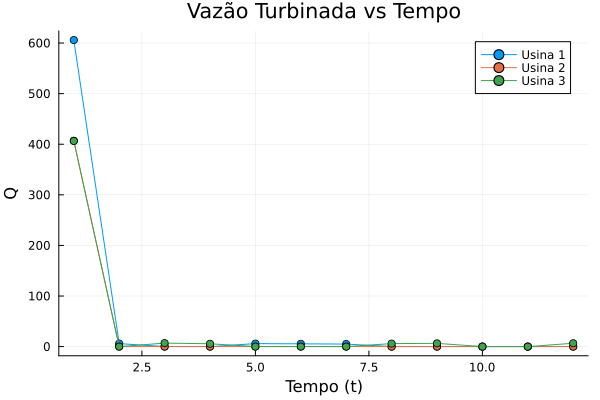

Salvando gráfico da Vazão Turbinada vs Tempo em: Qxt.png


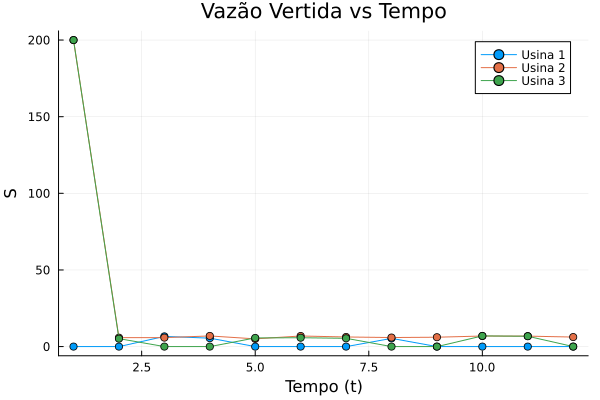

Salvando gráfico Vazão Vertida vs Tempo em: Sxt.png


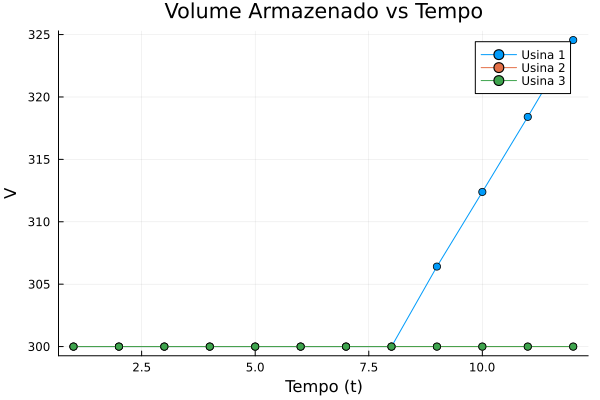

Salvando gráfico Volume Armazenado vs Tempo em: Vxt.png


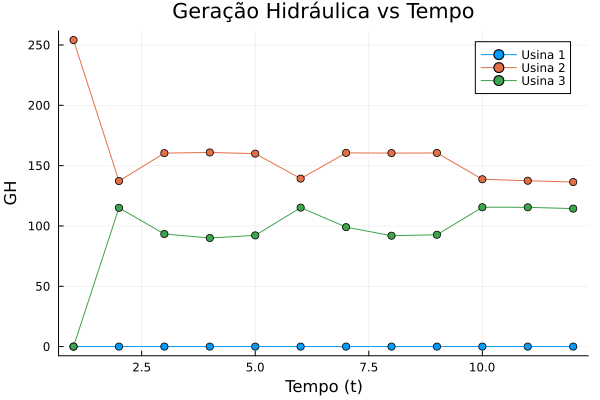

Salvando gráfico Geração Hidráulica vs Tempo em: GHxt.png


┌ Warning: Skipped marker arg sphere.
└ @ Plots C:\Users\diego\.julia\packages\Plots\gYkEG\src\args.jl:1155


Salvando gráfico da usina 1 em: VxQxGH_usina_1.png
Salvando gráfico da usina 2 em: VxQxGH_usina_2.png
Salvando gráfico da usina 3 em: VxQxGH_usina_3.png


┌ Warning: Skipped marker arg sphere.
└ @ Plots C:\Users\diego\.julia\packages\Plots\gYkEG\src\args.jl:1155
┌ Warning: Skipped marker arg sphere.
└ @ Plots C:\Users\diego\.julia\packages\Plots\gYkEG\src\args.jl:1155


In [6]:
# 5) Execução e resultados
# -------------------------
function run()
    scenario, hydros, thermals = load_parameters()
    model, Q, S, V, P_H, P_T = build_model(scenario, hydros, thermals)
    optimize!(model)
    println("Status: ", termination_status(model))
    println("Custo total (Reais): ", objective_value(model))
    println()
    ts = 1:scenario.T  # eixo do tempo
    for i in 1:length(hydros)
        println("== Usina Hidráulica ", i, " ==")
        for t in 1:scenario.T
            println("t=", t, ": Q=", value(Q[i,t]), ", S=", value(S[i,t]), ", V=", value(V[i,t]), ", PH=", value(P_H[i,t]))
        end
    end
    # Gráficos separados para cada usina
    # for i in 1:length(hydros)
    #     Q_values = [value(Q[i,t]) for t in ts]
    #     S_values = [value(S[i,t]) for t in ts]
    #     V_values = [value(V[i,t]) for t in ts]
    #     plot(ts, Q_values, marker=:circle, label="Usina $i", xlabel="Tempo (t)", ylabel="Vazão Turbinada Q", title="Vazão Turbinada vs Tempo - Usina $i")
    #     display(current())
    #     plot(ts, S_values, marker=:circle, label="Usina $i", xlabel="Tempo (t)", ylabel="Vazão Vertida S", title="Vazão Vertida S vs Tempo - Usina $i")
    #     display(current())
    #     plot(ts, V_values, marker=:circle, label="Usina $i", xlabel="Tempo (t)", ylabel="Volume Armazenado V", title="Volume Armazenado V vs Tempo - Usina $i")
    #     display(current())
    # end

    # Gráfico único Vazão Turbinada vs Tempo com todas as usinas
    plt = plot(title="Vazão Turbinada vs Tempo", xlabel="Tempo (t)", ylabel="Q", legend=:topright)
    for i in 1:length(hydros)
        Q_values = [value(Q[i,t]) for t in ts]
        plot!(ts, Q_values, label="Usina $i", marker=:circle)
    end
    display(current())
    # Salva em arquivo PNG
    filename = "Qxt.png"
    println("Salvando gráfico da Vazão Turbinada vs Tempo em: $filename")
    savefig(plt, filename)

    # Gráfico único Vazão Vertida vs Tempo com todas as usinas
    plt = plot(title="Vazão Vertida vs Tempo", xlabel="Tempo (t)", ylabel="S", legend=:topright)
    for i in 1:length(hydros)
        S_values = [value(S[i,t]) for t in ts]
        plot!(ts, S_values, label="Usina $i", marker=:circle)
    end
    display(current())
    # Salva em arquivo PNG
    filename = "Sxt.png"
    println("Salvando gráfico Vazão Vertida vs Tempo em: $filename")
    savefig(plt, filename)

    # Gráfico único Volume Armazenado vs Tempo com todas as usinas
    plt = plot(title="Volume Armazenado vs Tempo", xlabel="Tempo (t)", ylabel="V", legend=:topright)
    for i in 1:length(hydros)
        V_values = [value(V[i,t]) for t in ts]
        plot!(ts, V_values, label="Usina $i", marker=:circle)
    end
    display(current())
    # Salva em arquivo PNG
    filename = "Vxt.png"
    println("Salvando gráfico Volume Armazenado vs Tempo em: $filename")
    savefig(plt, filename)

    # Gráfico único Geração Hidráulica vs Tempo com todas as usinas
    plt = plot(title="Geração Hidráulica vs Tempo", xlabel="Tempo (t)", ylabel="GH", legend=:topright)
    for i in 1:length(hydros)
        GH_values = [value(P_H[i,t]) for t in ts]
        plot!(ts, GH_values, label="Usina $i", marker=:circle)
    end
    display(current())
    # Salva em arquivo PNG
    filename = "GHxt.png"
    println("Salvando gráfico Geração Hidráulica vs Tempo em: $filename")
    savefig(plt, filename)

    # ------------------------------------
    # Plot 3D de V × Q × GH para cada usina
    # ------------------------------------
    ts = 1:scenario.T

    for i in 1:length(hydros)
        # extrai as séries temporais de V, Q e GH
        V_vals = [value(V[i,t]) for t in ts]
        Q_vals = [value(Q[i,t]) for t in ts]
        GH_vals = [value(P_H[i,t]) for t in ts]
        

        # primeiro plota os pontos
        plt = scatter3d(
            V_vals, Q_vals, GH_vals;
            marker = (:sphere, 10),      # bolinhas pequenas
            xlabel = "V",
            ylabel = "Q",
            zlabel = "GH",
            title  = "Usina $i: V×Q×GH numerado por t",
            legend = false,
        )

        # agora adiciona o índice t ao lado de cada ponto
        for (x,y,z,t) in zip(V_vals, Q_vals, GH_vals, ts)
            annotate!(plt, x, y, z, text(string(t), 10, :black))
        end

        # Salva em arquivo PNG
        filename = "VxQxGH_usina_$(i).png"
        println("Salvando gráfico da usina $i em: $filename")
        savefig(plt, filename)
    end
end

run()